# Import Library

In [184]:
import pandas as pd
import numpy as np
import pandas as pd
import glob
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import calendar
import seaborn as sns


# Read data

In [185]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601,
             190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]
df = get_data(week_nums)

In [186]:
#in case ruin the dataframe
xyz=df.copy()
#df=x.copy()


# Clean data

In [187]:
#clean column names
df.rename(columns={'C/A': 'c_a', 'UNIT': 'unit', 'SCP': 'scp', 'STATION': 'station', 'LINENAME': 'linename', 'DIVISION': 'division', 'DATE': 'date','TIME': 'time', 'DESC': 'desc', 'ENTRIES': 'entries', df.columns[10]: 'exits'}, inplace=True)

#keep only subway divisions
df = df[(df['division'] == 'BMT') | (df['division'] == 'IND') | (df['division'] == 'IRT')]

#add Hour
df['hour']= list(map(lambda x: int(x.split(':')[0]),df['time'][:]))

#Add formatted timestamp column
df['timestamp'] = pd.to_datetime(df['date'] + " " + df['time'],format='%m/%d/%Y %H:%M:%S')

#add unique turnstile id
df['unique_turnstile_id'] = df['c_a'] + df['unit'] + ' ' + df['station'] + ' ' + df['scp']

#add day of week column
df['day_of_week'] = df.timestamp.dt.day_name()

df = df.reset_index()

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441725 entries, 0 to 3441724
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   index                int64         
 1   c_a                  object        
 2   unit                 object        
 3   scp                  object        
 4   station              object        
 5   linename             object        
 6   division             object        
 7   date                 object        
 8   time                 object        
 9   desc                 object        
 10  entries              int64         
 11  exits                int64         
 12  hour                 int64         
 13  timestamp            datetime64[ns]
 14  unique_turnstile_id  object        
 15  day_of_week          object        
dtypes: datetime64[ns](1), int64(4), object(11)
memory usage: 420.1+ MB


In [188]:
# Get rid of duplicate entries caused by "RECOVER AUD" in desc column, if any
df.sort_values(["c_a", "unit", "scp", "station", "timestamp"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["c_a", "unit", "scp", "station", "timestamp"], inplace=True)

In [189]:
df_23st = df[df['station'] == '47-50 STS ROCK']
df_23st.linename.unique()

array(['BDFM'], dtype=object)

In [190]:
def rename_station(row):
    if row.station == '23 ST' or row.station == '86 ST' or row.station == '125 ST' or row.station == '59 ST' or row.station == '96 ST' or row.station == '14 ST':
        row.station = row.station + ' ' + row.linename
    return row

df = df.apply(rename_station, axis='columns')

In [191]:
#keep only needed columns
df = df.loc[:,['station', 'entries', 'exits', 'timestamp','time', 'unique_turnstile_id','hour']]

# Volume diff

In [192]:
#calculate actual volumes for each record (record minus previous record)
df['diff_entries'] = abs(df.entries.diff())
df['diff_exits'] = abs(df.exits.diff())
df['total_traffic'] = df.diff_entries + df.diff_exits

#record index in new column (needed to identify first instance of turnstile data)
df['record_index'] = df.index
#df

In [193]:
#identify first rows of unique turnstile data
df_first_rows = df.groupby('unique_turnstile_id').first()

#index of records of first turnstile rows
list_index = df_first_rows.record_index.values

#drop first rows from main df
df.drop(list_index, inplace=True)

In [194]:
#keep only data with traffic > 0 and < 14400 (1 person per second)
df = df[(df['total_traffic'] > 0) & (df['total_traffic'] < 14400)]

In [195]:
df = df.reset_index()

In [ ]:
#drop record index column. no longer applies after re-indexing
#df.drop('record_index', axis=1)

In [196]:
df.drop(['record_index', 'entries', 'exits'], axis=1, inplace=True)
df["weekday"] = df["timestamp"].dt.day_name()
df_by_station = (df.groupby("station").agg({"total_traffic": 'sum'}).
                 reset_index().sort_values(by="total_traffic", ascending=False))

In [198]:
df_by_station.head(10)

,station,total_traffic
69,34 ST-PENN STA,33322393.0
245,GRD CNTRL-42 ST,29065257.0
67,34 ST-HERALD SQ,25012557.0
349,TIMES SQ-42 ST,20961309.0
19,14 ST-UNION SQ,20533165.0
76,42 ST-PORT AUTH,19969747.0
238,FULTON ST,18241509.0
187,CANAL ST,14546518.0
94,59 ST COLUMBUS,13759907.0
80,47-50 STS ROCK,12041838.0


# Volume by Hour

In [199]:
df.head()
df_by_hour=df
#df_by_hour.info()

#Calculate Hourly traffic
df_by_hour['Hourly_traffic']=df_by_hour['total_traffic']/4


In [200]:
#plit Column containing lists into different rows
df_by_hour['Hour']= list(map(lambda x : [x-1, x-2, x-3, x-4],df_by_hour['hour']))
df_by_hour_update = pd.DataFrame({
      col:np.repeat(df_by_hour[col].values, df_by_hour['Hour'].str.len())
      for col in df_by_hour.columns.drop('Hour')}
    ).assign(**{'Hour':np.concatenate(df_by_hour['Hour'].values)})[df_by_hour.columns]

df_by_hour_update

def check_neg_hour(x):
    if x<0: 
        x+=24
    else:
        pass
    return x

df_by_hour_update['Hour']=list(map(check_neg_hour, df_by_hour_update['Hour']))

#df_by_hour_update

In [201]:
# Add Column for Month
df_by_hour_update["Month"]=pd.DatetimeIndex(df_by_hour_update["timestamp"]).month

df_by_hour_update["Month"]=list(map(lambda x: calendar.month_name[x],df_by_hour_update["Month"]))



In [202]:
df_by_hour_update

dic_hour={"0-4":[0,1,2,3],"04-08":[4,5,6,7],
              "08-12":[8,9,10,11],"12-16":[12,13,14,15],
             "16-20":[16,17,18,19],"20-24":[20,21,22,23]}
def fillin_hour_range(x):
    for i, cata in dic_hour.items():
        if x in cata:
            x=i
    return x
        

df_by_hour_update['Hour']= list(map(fillin_hour_range,df_by_hour_update['Hour']))
df_by_hour_update

,index,station,timestamp,time,unique_turnstile_id,hour,diff_entries,diff_exits,total_traffic,weekday,Hourly_traffic,Hour,Month
0,3245396,EASTCHSTER/DYRE,2019-07-26 17:00:00,17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,16-20,July
1,3245396,EASTCHSTER/DYRE,2019-07-26 17:00:00,17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,12-16,July
2,3245396,EASTCHSTER/DYRE,2019-07-26 17:00:00,17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,12-16,July
3,3245396,EASTCHSTER/DYRE,2019-07-26 17:00:00,17:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,17,38.0,51.0,89.0,Friday,22.25,12-16,July
4,3245395,EASTCHSTER/DYRE,2019-07-26 13:00:00,13:00:00,R730R431 EASTCHSTER/DYRE 00-00-04,13,95.0,52.0,147.0,Friday,36.75,12-16,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11373727,1,59 ST NQR456W,2019-03-30 04:00:00,04:00:00,A002R051 59 ST 02-00-00,4,23.0,46.0,69.0,Saturday,17.25,0-4,March
11373728,0,59 ST NQR456W,2019-03-30 00:00:00,00:00:00,A002R051 59 ST 02-00-00,0,20.0,8.0,28.0,Saturday,7.00,20-24,March
11373729,0,59 ST NQR456W,2019-03-30 00:00:00,00:00:00,A002R051 59 ST 02-00-00,0,20.0,8.0,28.0,Saturday,7.00,20-24,March
11373730,0,59 ST NQR456W,2019-03-30 00:00:00,00:00:00,A002R051 59 ST 02-00-00,0,20.0,8.0,28.0,Saturday,7.00,20-24,March


### Plot for 34 ST-PENN STA (Top 1)

In [207]:
#plot_penn_34.groupby(["station","Month","Hour"]).sum()


Hour
0-4       3647220.75
04-08     8167214.75
08-12     6962065.25
12-16    10125879.75
16-20     3686248.50
20-24      733764.00
Name: Hourly_traffic, dtype: float64


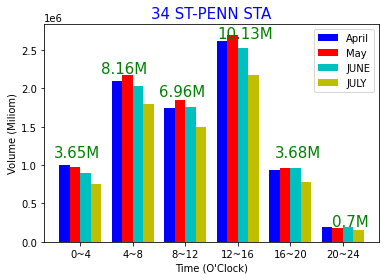

In [279]:
#34 ST-PENN STA
penn_34=df_by_hour_update[df_by_hour_update.station=="34 ST-PENN STA"]

#sorted(penn_34['hour'].value_counts())
#penn_34['hour'].value_counts()
plot_penn_34=penn_34.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()
#df_penn_34.head(10)
#plot_penn_34

apr=plot_penn_34[plot_penn_34.Month=='April']
may=plot_penn_34[plot_penn_34.Month=='May']
jun=plot_penn_34[plot_penn_34.Month=='June']
july=plot_penn_34[plot_penn_34.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('34 ST-PENN STA',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')
#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.text(-0.5, 1100000, '3.65M',
        color='green', fontsize=15)

plt.text(0.4, 2200000, '8.16M',
        color='green', fontsize=15)

plt.text(1.5, 1900000, '6.96M',
        color='green', fontsize=15)


plt.text(2.6, 2650000, '10.13M',
        color='green', fontsize=15)


plt.text(3.7, 1100000, '3.68M',
        color='green', fontsize=15)

plt.text(4.8, 200000, '0.7M',
        color='green', fontsize=15)

print(penn_34.groupby(["Hour"])["Hourly_traffic"].sum())
plt.legend(['April','May','JUNE','JULY'])
plt.show();



### Plot for GRD CNTRL-42 ST (Top 2)

### GRD_CNTRL=df_by_hour_update[df_by_hour_update.station=="GRD CNTRL-42 ST"]
plot_GRD_CNTRL=GRD_CNTRL.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_GRD_CNTRL



apr=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='April']
may=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='May']
jun=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='June']
july=plot_GRD_CNTRL[plot_GRD_CNTRL.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('GRD CNTRL-42 ST',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')


plt.text(-0.5, 1200000, '3.32M',
        color='green', fontsize=15)

plt.text(0.4, 2000000, '7.62M',
        color='green', fontsize=15)

plt.text(1.5, 1750000, '6.17M',
        color='green', fontsize=15)

plt.text(2.6, 2350000, '8.94M',
        color='green', fontsize=15)

plt.text(3.7, 950000, '3.09M',
        color='green', fontsize=15)

plt.text(4.8, 175000, '0.47M',
        color='green', fontsize=15)

print(GRD_CNTRL.groupby(["Hour"])["Hourly_traffic"].sum())



#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();






# Plot for 34 ST-HERALD SQ (Top 3)

Hour
0-4      1645874.75
04-08    5920634.50
08-12    5297996.50
12-16    8592700.25
16-20    3106555.25
20-24     448795.75
Name: Hourly_traffic, dtype: float64


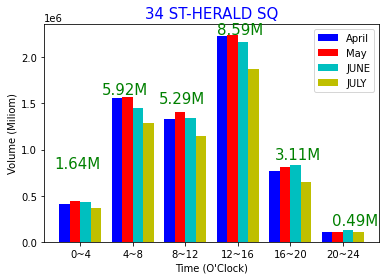

In [274]:
HERALD_34=df_by_hour_update[df_by_hour_update.station=="34 ST-HERALD SQ"]
plot_HERALD_34=HERALD_34.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_HERALD_34


apr=plot_HERALD_34[plot_HERALD_34.Month=='April']
may=plot_HERALD_34[plot_HERALD_34.Month=='May']
jun=plot_HERALD_34[plot_HERALD_34.Month=='June']
july=plot_HERALD_34[plot_HERALD_34.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('34 ST-HERALD SQ',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')

plt.text(-0.5, 800000, '1.64M',
        color='green', fontsize=15)

plt.text(0.4, 1600000, '5.92M',
        color='green', fontsize=15)

plt.text(1.5, 1500000, '5.29M',
        color='green', fontsize=15)

plt.text(2.6, 2250000, '8.59M',
        color='green', fontsize=15)

plt.text(3.7, 900000, '3.11M',
        color='green', fontsize=15)

plt.text(4.8, 175000, '0.49M',
        color='green', fontsize=15)

print(HERALD_34.groupby(["Hour"])["Hourly_traffic"].sum())



#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();



### Plot for TIMES SQ-42 ST (Top 4)

In [27]:
TIMES_SQ['hour'].unique()

array([16, 12,  8,  4,  0, 20, 14, 13,  7, 19,  9, 18, 10, 11])

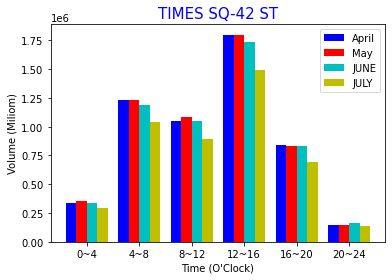

In [214]:
TIMES_SQ=df_by_hour_update[df_by_hour_update.station=="TIMES SQ-42 ST"]
plot_TIMES_SQ=TIMES_SQ.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_TIMES_SQ


apr=plot_TIMES_SQ[plot_TIMES_SQ.Month=='April']
may=plot_TIMES_SQ[plot_TIMES_SQ.Month=='May']
jun=plot_TIMES_SQ[plot_TIMES_SQ.Month=='June']
july=plot_TIMES_SQ[plot_TIMES_SQ.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('TIMES SQ-42 ST',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')
#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();

#### Plot for 14 ST-UNION SQ (Top 5)

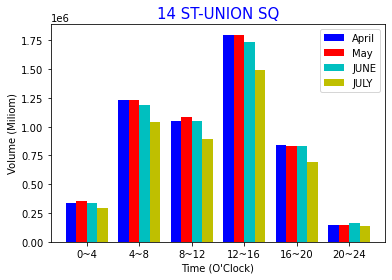

In [215]:
UNION_SQ_14=df_by_hour_update[df_by_hour_update.station=="14 ST-UNION SQ"]
plot_UNION_SQ_14=TIMES_SQ.groupby(["station","Month","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()

plot_UNION_SQ_14


apr=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='April']
may=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='May']
jun=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='June']
july=plot_UNION_SQ_14[plot_UNION_SQ_14.Month=='July']


xticks = np.arange(6)+ (6 / 2.) * 0.2
x_jun = np.arange(len(jun.Hour))
x_july=np.arange(len(july.Hour))
x_apr=np.arange(len(apr.Hour))
x_may=np.arange(len(may.Hour))

plt.bar(x_apr-0.3, apr.Hourly_traffic, color = 'b', width = 0.2);
plt.bar(x_may-0.1, may.Hourly_traffic,color = 'r', width = 0.2);
plt.bar(x_jun+0.1, jun.Hourly_traffic,color = 'c', width = 0.2);
plt.bar(x_july+0.3, july.Hourly_traffic,color = 'y', width = 0.2);
#plt.xlim([0 - 0.1, max(xticks) + (6 * 0.5)])
plt.title('14 ST-UNION SQ',family='sans-serif',fontsize = 15,color='b');
plt.xlabel('Time (O\'Clock)')
plt.ylabel('Volume (Miliom)')
#plt.linewidth(5)
plt.xticks(np.arange(6),('0~4', '4~8', '8~12', '12~16', '16~20', '20~24'))
#plt.yticks(np.linspace(0, 700000, 6))
plt.legend(['April','May','JUNE','JULY'])
plt.show();

# Volumn by each day of week

In [216]:
df_week=df_by_hour_update
calendar.day_name[df_week["timestamp"][1].weekday()]
df_week["Week"]= list(map(lambda x: calendar.day_name[x.weekday()], 
                          df_week["timestamp"]))


<AxesSubplot:xlabel='Week', ylabel='Hour'>

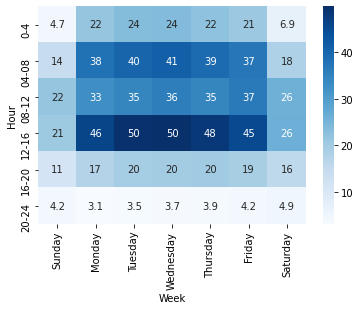

In [217]:
a=df_week.groupby(["Week","Hour"]).agg({'Hourly_traffic':'sum'}).reset_index()
a['Hourly_traffic']=a['Hourly_traffic']/1000000
pv=a.pivot('Hour','Week','Hourly_traffic')

pv = pv[['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]
sns.heatmap(pv, cmap="Blues", annot=True)


#week['VOLUME_NUM']=week['VOLUME_NUM'].apply(lambda x: '%.f' % x)
#cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#stations_weekly = stations_weekly.groupby(['DAY OF WEEK']).sum().reindex(cats) 
#stations_weekly.reset_index(inplace=True)
#p1=sns.heatmap(a)